In [87]:
# Imports

import nltk
import requests
import time
import pandas as pd
import os
import re
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import streamlit as st
import torch
import numpy as np
import tensorflow as tf

from torch.utils.tensorboard import SummaryWriter
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from langchain import PromptTemplate, LLMChain
from dotenv import find_dotenv, load_dotenv
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorboard.plugins import projector
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
from tensorboard.plugins import projector

load_dotenv()

True

In [11]:
# ---------- Functions ---------- #

# ---------- Loading the dataset ---------- #

df = pd.read_csv('yelp_reviews.csv')

df.drop_duplicates(inplace=True)
df.dropna(subset=['text', 'rating', 'location'], inplace=True)

# ---------- Preprocessing ---------- #

# Translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].astype(str)

# Check if text contains Chinese characters
def contains_chinese(text):
    return bool(re.search('[\u4e00-\u9fff]', text))

# Translation function (from Chinese to English)
def translate_text(text):
    if contains_chinese(text):
        return translator(text)[0]['translation_text']
    else:
        return text

In [12]:
# Lemmatisation & Tokenisation function
def tokenisation(reviews, allowed_postags=["NOUN", "ADJ", "VERBS", "ADV"]):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    reviews_out = []
    tokens = []

    for review in reviews:
        doc = nlp(review) 
        reviews_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]))
    
    for text in reviews_out:
        new = gensim.utils.simple_preprocess(text, deacc=False) # We do not remove the accent marks because we deem them important for French restaurants reviews
        tokens.append(new)

    return tokens

# Preprocessing function
def preprocessing(text):
    # Corrected spelling on lower case text
    corrected_text = str(TextBlob(text.lower()).correct())

    # Translation
    cleaned_text = translate_text(str(corrected_text))

    return cleaned_text

# Apply preprocessing and tokenisation
df['cleaned_text'] = df['text'].apply(preprocessing)
df['tokens'] = tokenisation(df['cleaned_text'])

In [ ]:
# Summarisation

max_length_coef = 1.5
min_length_coef = 2

summariser = pipeline("summarization", model="facebook/bart-large-cnn")
summarised_text = df['text'].apply(lambda x: summariser(x, max_length=round(len(x)/max_length_coef), min_length=round(len(x)/min_length_coef), do_sample=False))
df['summarised_text'] = summarised_text.apply(lambda x: x[0]['summary_text'])

In [60]:
df['restaurant_id'] = [(i // 10) + 1 for i in range(len(df))]

In [61]:
# ---------- Highlighting frequent words ---------- #

review_frequent_words = {}

def get_frequency(restaurant_id):

    # Word Frequency Analysis
    all_words = [word for tokens in df[df['restaurant_id'] == restaurant_id]['tokens'] for word in tokens]
    word_freq = Counter(all_words)

    # N-gram Analysis
    bigrams = ngrams(all_words, 2)
    bigram_freq = Counter(bigrams)

    # Tri-gram Analysis
    trigrams = ngrams(all_words, 3)
    trigram_freq = Counter(trigrams)

    return [word_freq, bigram_freq, trigram_freq]

for restaurant_id in df['restaurant_id']:
    review_frequent_words[restaurant_id] = get_frequency(restaurant_id)

In [63]:
review_frequent_words_df = pd.DataFrame.from_dict(review_frequent_words, orient='index', columns=['word_freq', 'bigram_freq', 'trigram_freq'])
# review_frequent_words_df['word_freq'] = review_frequent_words_df['word_freq'].apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))
review_frequent_words_df

,word_freq,bigram_freq,trigram_freq
1,"{'time': 5, 'service': 3, 'food': 3, 'amazing'...","{('amazing', 'service'): 1, ('service', 'atten...","{('amazing', 'service', 'attentive'): 1, ('ser..."
2,"{'food': 6, 'service': 4, 'life': 3, 'heart': ...","{('heart', 'belly'): 1, ('belly', 'happily'): ...","{('heart', 'belly', 'happily'): 1, ('belly', '..."
3,"{'food': 6, 'service': 5, 'time': 4, 'great': ...","{('review', 'private'): 1, ('private', 'party'...","{('review', 'private', 'party'): 1, ('private'..."
4,"{'restaurant': 3, 'food': 3, 'pm': 3, 'great':...","{('present', 'thoughtful'): 1, ('thoughtful', ...","{('present', 'thoughtful', 'son'): 1, ('though..."
5,"{'service': 3, 'food': 3, 'experience': 3, 'go...","{('great', 'thing'): 1, ('thing', 'place'): 1,...","{('great', 'thing', 'place'): 1, ('thing', 'pl..."
...,...,...,...
58,"{'service': 7, 'amazing': 4, 'experience': 3, ...","{('demand', 'river'): 1, ('river', 'floor'): 1...","{('demand', 'river', 'floor'): 1, ('river', 'f..."
59,"{'dining': 4, 'experience': 3, 'art': 3, 'love...","{('ten', 'board'): 1, ('board', 'honestly'): 1...","{('ten', 'board', 'honestly'): 1, ('board', 'h..."
60,"{'food': 4, 'alliance': 4, 'server': 3, 'great...","{('service', 'recent'): 1, ('recent', 'server'...","{('service', 'recent', 'server'): 1, ('recent'..."
61,"{'service': 4, 'friendly': 3, 'course': 3, 're...","{('kid', 'friendly'): 1, ('friendly', 'actuall...","{('kid', 'friendly', 'actually'): 1, ('friendl..."


In [4]:
# ---------- Topic Modelling ---------- #

# We convert the tokens into tuples where we'll have the word index (its placement on the map) and its frequency
id2word = corpora.Dictionary(df['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=10)
pyLDAvis.display(vis)

/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [5]:
def get_topic_distribution(lda_model, bow):
    return lda_model.get_document_topics(bow, minimum_probability=0)

df['topic_distribution'] = [get_topic_distribution(lda_model, corpus[i]) for i in range(len(df))]

def get_top_topics(topic_distribution, num_topics=5):
    # Sort the topics by probability and select the top ones
    return sorted(topic_distribution, key=lambda x: x[1], reverse=True)[:num_topics]

df['top_topics'] = df['topic_distribution'].apply(lambda x: get_top_topics(x, 11 - 1))

def label_topics(topic_list, lda_model):
    labels = []
    for topic_id, _ in topic_list:
        # Get the top words in the topic
        words = lda_model.show_topic(topic_id, 5)
        # Create a label (e.g., by joining the top words)
        label = [word for word, prob in words]
        labels.append(label)
    return labels

def topicise(labels, label_dict):
    topics = []

    for topic_list in labels:
        for key, value in label_dict.items():
            if set(topic_list) == set(value):
                topics.append(key)

    return topics

label_dict = {
    'Quality of Food & Service' : ['service', 'food', 'restaurant', 'good', 'great'],
    'French Dining Experience' : ['dinner', 'meal', 'french', 'reservation', 'little'],
    'Atmosphere' : ['speak', 'dining', 'menu', 'experience', 'soup'],
    'Price' : ['course', 'table', 'thing', 'life', 'party'],
    'Special Occasions' : ['birthday', 'time', 'family', 'really', 'warm'],
    'Ambience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Dining Experience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Staff' : ['year', 'last', 'time', 'first', 'second'],
    'Menu' : ['atmosphere', 'area', 'bit', 'high', 'mummy'],
    'Drinks' : ['way', 'incredible', 'class', 'wall', 'mood'] 
}

df['top_topic_labels'] = df['top_topics'].apply(lambda x: label_topics(x, lda_model))
df['topics'] = df['top_topic_labels'].apply(lambda x: topicise(x, label_dict))
df.drop(columns=['topic_distribution', 'top_topics'], inplace=True)

## Word2vec

In [13]:
# Train the model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("yelp_reviews.model")

In [14]:
# Find similar words
print(word2vec_model.wv.most_similar('good', topn=5))

# Find word analogies
print(word2vec_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))

def semantic_search(query_word, model, topn=5):
    similar_words = model.wv.most_similar(query_word, topn=topn)
    return [word for word, similarity in similar_words]

# Example usage
search_results = semantic_search('onion', word2vec_model, topn=5)
print(search_results)

# To put into streamlit

# import streamlit as st

# st.title("Restaurant Finder")

# # Semantic search input
# user_input = st.text_input("Search for restaurants with themes like:")
# if user_input:
#     search_terms = semantic_search(user_input, word2vec_model, topn=5)
#     st.write("Restaurants related to:", ", ".join(search_terms))

[('french', 0.792743980884552), ('food', 0.7866317629814148), ('dinner', 0.7773987054824829), ('service', 0.7734721302986145), ('place', 0.769766092300415)]
[('worker', 0.34493646025657654)]
['restaurant', 'french', 'food', 'course', 'place']


In [48]:
# Phrases alogrithm

min_count = 3
threshold = 5

phrases = Phrases(df['tokens'], min_count=min_count, threshold=threshold)
phraser = Phraser(phrases)

df['bigrams'] = [phraser[tokens] for tokens in df['tokens']]
df['trigrams'] = [phraser[bigrams] for bigrams in df['bigrams']]

# Output: [['the', 'new_york', 'times'], ['new_york', 'post']]

In [69]:
vector_size = 100
window = 5
min_count = 1
workers = 4

# Training the model
word2vec_model = Word2Vec(sentences=df['bigrams'], vector_size=vector_size, window=window, min_count=min_count, workers=workers)

# Save the model
word2vec_model.save("word2vec.model")

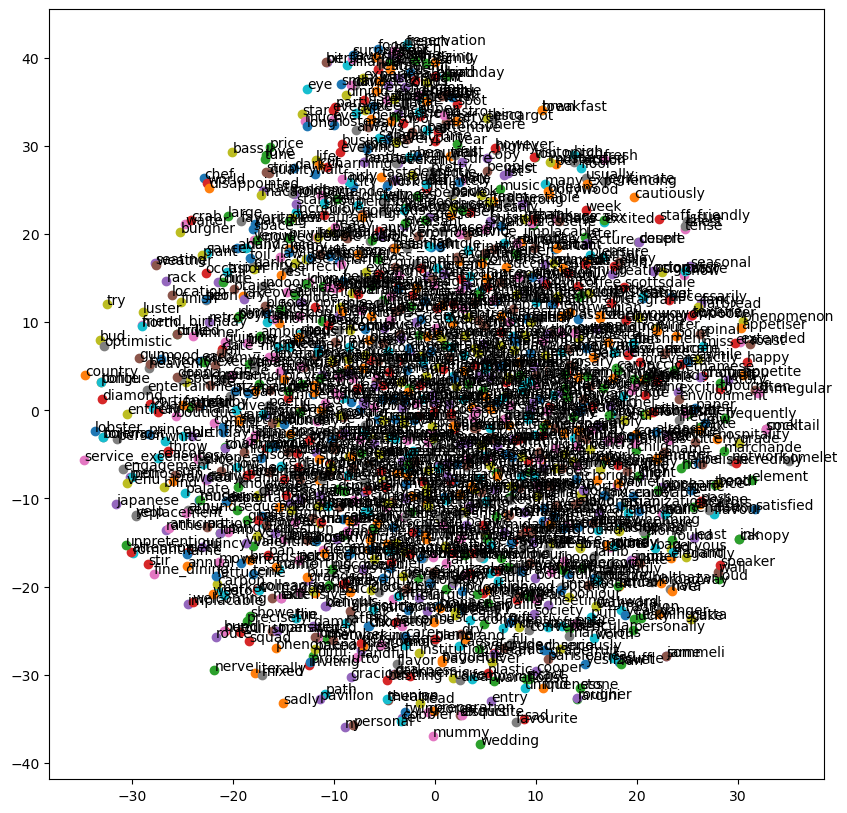

In [117]:
# We retrieve the word vectors from the model
words = list(word2vec_model.wv.index_to_key)
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# We reduce the dimensions to 2D using t-SNE
tsne = TSNE(n_components=2)  # Adjust the perplexity value as needed
word_vectors_2d = tsne.fit_transform(word_vectors)

# We plot our results
plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.show()

In [121]:
file_name = "word2vec.model"
model = gensim.models.keyedvectors.KeyedVectors.load(file_name)

max_size = len(model.wv.index_to_key)-1

w2v = np.zeros((max_size,model.vector_size))

if not os.path.exists('projections'):
    os.makedirs('projections')
    
with open("projections/metadata.tsv", 'w+') as file_metadata:
    
    for i, word in enumerate(model.wv.index_to_key[:max_size]):
        
        #store the embeddings of the word
        w2v[i] = model.wv[word]
        
        #write the word to a file 
        file_metadata.write(word + '\n')

tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.Saver()
writer = tf.compat.v1.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()

embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)
saver.save(sess, 'projections/model.ckpt', global_step=max_size)

2024-01-19 23:29:34.484810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
2024-01-19 23:29:34.484831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'projections/model.ckpt-1457'

In [91]:
model = Word2Vec.load("word2vec.model")
keyed_vectors = Word2Vec.load("word2vec.model")
max_size = len(keyed_vectors.wv.index_to_key)

# Assuming model_from_file is your Word2Vec model loaded from file
max_size = len(model.wv.index_to_key)  # Use 'index_to_key' for gensim 4.x
w2v = np.zeros((max_size, model.vector_size))  # Use 'vector_size' instead of 'layer1_size'

print(w2v)

if not os.path.exists('projections'):
    os.makedirs('projections')

with open("projections/metadata.tsv", 'w+') as file_metadata:
    for i, word in enumerate(model.wv.index_to_key[:max_size]):  # Use 'index_to_key' for gensim 4.x
        # store the embeddings of the word
        w2v[i] = model.wv[word]
        # write the word to a file
        file_metadata.write(word + '\n')

# TensorFlow 2.x code for setting up the TensorBoard projector
embedding_variable = tf.Variable(w2v, trainable=False, name='embedding')

# Initialize variables
# No need for a session in TensorFlow 2.x, use 'tf.compat.v1.global_variables_initializer()' directly
tf.compat.v1.global_variables_initializer()

# Create a checkpoint from embedding
checkpoint = tf.train.Checkpoint(embedding=embedding_variable)
checkpoint.save(os.path.join('projections', 'embedding.ckpt'))

# Set up the projector config
config = projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding_config.metadata_path = 'metadata.tsv'  # Update the file path to a string

# Use the writer from the new TensorFlow 2.x API
writer = tf.summary.create_file_writer('projections')

# Use the projector from the new TensorFlow 2.x API
with writer.as_default():
    projector.visualize_embeddings(writer, config)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: expected str, bytes or os.PathLike object, not _ResourceSummaryWriter

In [25]:
from scipy.spatial.distance import euclidean, cosine

# Example: distance between two words
word1_vec = word2vec_model.wv['food']
word2_vec = word2vec_model.wv['french']

euclidean_dist = euclidean(word1_vec, word2_vec)
cosine_dist = cosine(word1_vec, word2_vec)

euclidean_dist, cosine_dist

(0.08205384016036987, 0.1876145601272583)

In [ ]:
from scipy.spatial.distance import euclidean, cosine

# Example: distance between two words
word1_vec = word2vec_model.wv['word1']
word2_vec = word2vec_model.wv['word2']

euclidean_dist = euclidean(word1_vec, word2_vec)
cosine_dist = cosine(word1_vec, word2_vec)


In [28]:
def semantic_search(query_word, model, topn=10):
    similar_words = model.wv.most_similar(query_word, topn=topn)
    return [word for word, similarity in similar_words]

# Example usage
search_results = semantic_search('wine', word2vec_model)

search_results

['food',
 'french',
 'alliance',
 'great',
 'night',
 'staff',
 'restaurant',
 'good',
 'server',
 'menu']

In [29]:
def semantic_search(query_word, model, topn=10):
    query_vector = model.wv[query_word]
    all_words = model.wv.index_to_key

    # Calculate cosine distance between query and all other words
    distances = {word: cosine(query_vector, model.wv[word]) for word in all_words}
    
    # Sort words by distance (lower is more similar)
    sorted_words = sorted(distances, key=distances.get)

    # Return the topn closest words
    return sorted_words[:topn]

# Example usage
search_results = semantic_search('wine', word2vec_model)

search_results

['wine',
 'food',
 'french',
 'alliance',
 'great',
 'night',
 'staff',
 'restaurant',
 'good',
 'server']

We've decided to go with this: BERT for Text Classification: Given its context-aware nature and superior performance in understanding nuances, BERT is generally the better choice for text classification.
Word2Vec for Semantic Search: For semantic search tasks, Word2Vec's efficiency and effectiveness in finding similar words make it a strong choice.

## TF-IDF

In [68]:
# TF-IDF & Classical ML (BM25) - Supervised Learning

# TD-IDF - Use it for sentiment analysis

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform your review data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))

# BM25 - use it for recommendation and search engine

# Create a BM25 vectorizer
bm25_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform your review data
bm25_matrix = bm25_vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))

In [86]:
# Hugging face sentiment analysis - to modify as this is from a video!

tokeniser = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")


tokens = tokeniser.encode('It was great, I will come back again.', return_tensors="pt")
result = model(tokens)
result.logits
int(torch.argmax(result.logits))+1

def extract_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings[0].numpy()  # Extract embeddings for the first (and only) token

def sentiment_score(review):
    tokens = tokeniser.encode(review, return_tensors="pt")
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

example_sentence = 'It was great, I will come back again.'
embeddings = extract_embeddings(example_sentence)

def write_embeddings_to_tensorboard(embeddings, output_dir):
    # Create a TensorFlow summary writer
    writer = tf.summary.create_file_writer(output_dir)

    # Create a projector configuration
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()

    # Assign the embeddings and their metadata
    embedding.tensor_name = "word_embeddings"
    embedding.metadata_path = "metadata.tsv"

    with writer.as_default():
        # Write embeddings
        tf.summary.tensor("word_embeddings", embeddings, step=0)

    # Write metadata (words)
    with open(output_dir + "/metadata.tsv", 'w', encoding='utf-8') as file:
        file.write("Word\n")
        for word in example_sentence.split():
            file.write(word + "\n")

# Write embeddings to a directory for TensorBoard
output_directory = "tensorboard_embeddings"
write_embeddings_to_tensorboard(embeddings, output_directory)

df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import streamlit as st

def resize_image(image_path, width, height):
    image = Image.open(image_path)
    resized_image = image.resize((width, height))
    return resized_image

st.set_page_config(page_title="Gastonomy", page_icon="🍽️", layout="wide")
    
st.sidebar.markdown("Select a city and a restaurant to generate a review.")
city = st.sidebar.selectbox("City", sorted(df['location'].unique()))

# Dictionary mapping city names to image filenames
city_images = {
    'New Orleans': 'resources/new-orleans.jpg',
    'New York City': 'resources/new-york.jpg',
    'Chicago': 'resources/chicago.jpg',
    'Los Angeles': 'resources/los-angeles.jpg',
    'San Francisco': 'resources/san-francisco.jpg',
    'Philadelphia': 'resources/philadelphia.jpg',
    'Las Vegas': 'resources/las-vegas.jpg',
    'Houston': 'resources/houston.jpg',
    'Phoenix': 'resources/phoenix.jpg',
    'Miami': 'resources/miami.jpg'
}

# Display image based on selected city
if city in city_images:
    image_filename = city_images[city]
    resized_image = resize_image(image_filename, 1920, 1080)
    st.image(resized_image, caption=city)
else:
    st.write("Image not found for selected city.")

st.title("Restaurant Review Analysis")

st.header("Quel sont les aspects les plus importants pour vous dans un restaurant?")
topics = st.multiselect("Choisissez vos aspects", sorted(label_dict.keys()))

2024-01-17 16:33:50.937 
  command:

    streamlit run /Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


A faire: Faire choisir a l'utilisateur un ou des topics qu'il aimerait aborder. (S'il est interesse par le food quality par exemple on lui recommandera un restaurant avec une tres bonne food quality - peux-t-on recuperer les restaurants qui correspondent aux avis?).

Montrer aussi les topics principaux les plus importants pour les resturants francais de chaque ville

Later on, maybe use these topics to enhance the importance of them in summarised reviews.

What I suggest is this: Topics principaux par villes. On demande a l'utilisateur de choisir ce qu'il prefere a travers un chatbot et ensuite on trouve les restaurants avec les meilleurs topics et de ce resturant on montre aussi ses meilleurs atouts avec les topics.